In [1]:
import pm4py
log_all = pm4py.read_xes('BPI_Challenge_2012.xes')

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [2]:
print(f'activities: {sorted(list(pm4py.get_event_attribute_values(log_all,"concept:name").keys()))}')

activities: ['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED', 'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED', 'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads', 'W_Beoordelen fraude', 'W_Completeren aanvraag', 'W_Nabellen incomplete dossiers', 'W_Nabellen offertes', 'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']


In [3]:
# We only look at subtraces of activities starting with an 'O'.
log = pm4py.filter_event_attribute_values(
    log_all,
    "concept:name",
    ['O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT', 'O_SENT_BACK'],
    level="event",
    retain=True)

In [4]:
pm4py.write_xes(log, "BPI_Challenge_2012_only_O.xes")

exporting log, completed traces ::   0%|          | 0/5015 [00:00<?, ?it/s]

### Analysis

In [1]:
import pm4py
log = pm4py.read_xes('BPI_Challenge_2012_only_O.xes')

parsing log, completed traces ::   0%|          | 0/5015 [00:00<?, ?it/s]

The `AMOUNT_REQ` attribute is stored as a string inside the XES file. We change this in order to help all techniques capture the attribute's semantics.

In [2]:
for trace in log:
    trace.attributes['AMOUNT_REQ_NUM'] = float(trace.attributes['AMOUNT_REQ'])

In [3]:
from exdpn.petri_net import get_petri_net
net, im, fm = get_petri_net(log, miner_type='IM')

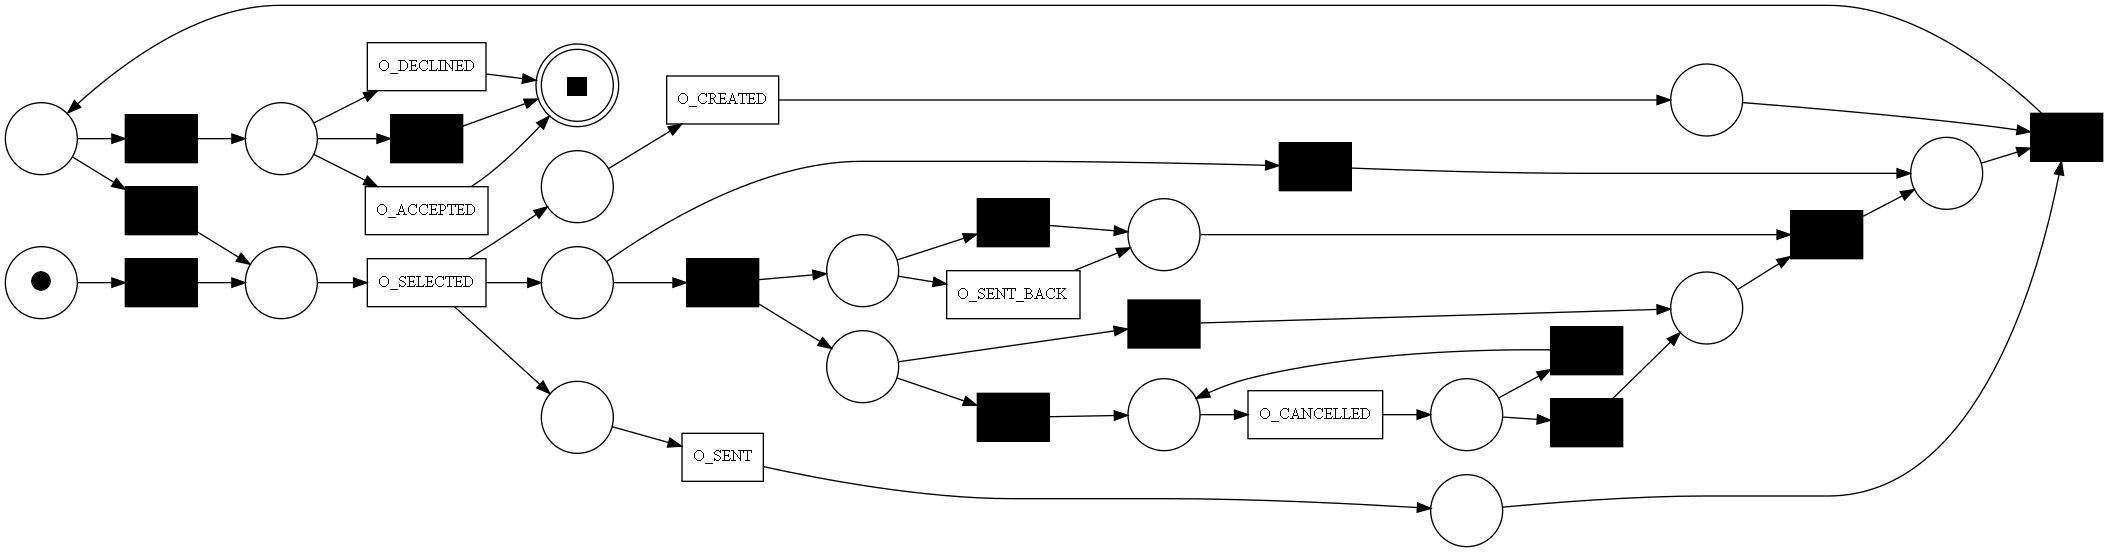

In [4]:
pm4py.view_petri_net(net, im, fm)

As we can see, we have three decision points in our log / the corresponding Petri net.
We now take all trace-level and event-level attributes that do not have ID-esque semantics:

In [5]:
event_attrs = list(pm4py.get_event_attributes(log))
trace_attrs = list(pm4py.get_trace_attributes(log))

In [6]:
trace_attrs.remove("REG_DATE")
trace_attrs.remove("AMOUNT_REQ")
trace_attrs

['AMOUNT_REQ_NUM']

In [7]:
event_attrs = [attr for attr in event_attrs if max(list(pm4py.get_event_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
event_attrs.remove("time:timestamp")
event_attrs.remove("concept:name")
event_attrs

['org:resource']

Decision Trees without hyperparameter:

In [8]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True,
                     hyperparameters={ML_Technique.DT: {}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_6'... Done
-> Evaluating guards at decision point 'p_14'... Done
-> Evaluating guards at decision point 'p_12'... Done
-> Evaluating guards at decision point 'p_16'... Done
-> Evaluating guards at decision point 'p_4'... Done
-> Evaluating guards at decision point 'p_19'... Done


In [9]:
_ = dpn.get_best()

-> Best machine learning technique at decision point 'p_6': Decision Tree w/ performance 0.7718367506969257
-> Best machine learning technique at decision point 'p_14': Decision Tree w/ performance 0.9615727042967561
-> Best machine learning technique at decision point 'p_12': Decision Tree w/ performance 0.7932006983518896
-> Best machine learning technique at decision point 'p_16': Decision Tree w/ performance 0.9556023276116108
-> Best machine learning technique at decision point 'p_4': Decision Tree w/ performance 0.7408277072813061
-> Best machine learning technique at decision point 'p_19': Decision Tree w/ performance 0.9167329033326338


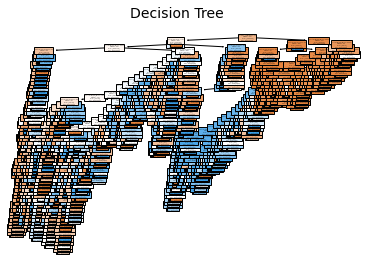

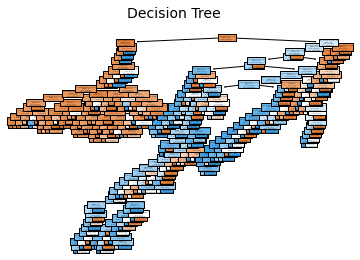

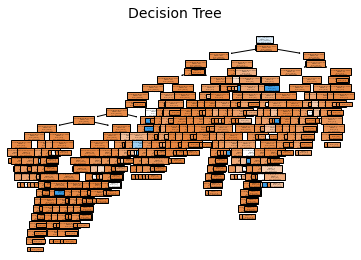

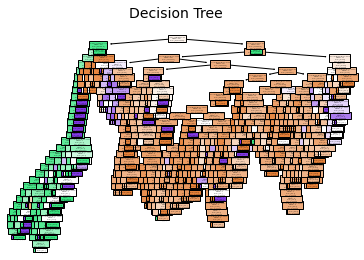

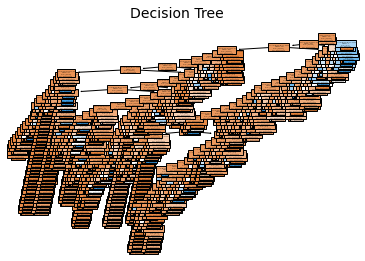

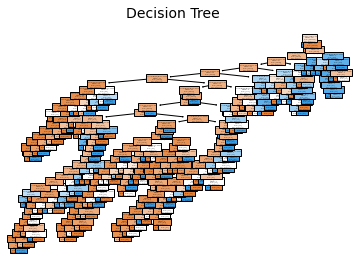

In [13]:
dps = list(dpn.decision_points)
for p in dps:
    dt_guard = dpn.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    dt_explainable_representation = dt_guard.get_explainable_representation()

Data Petri Net with hyperparameter:

In [14]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, ML_Technique.XGB, ML_Technique.NN, ML_Technique.LR, ML_Technique.SVM, ML_Technique.RF]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True,
                     hyperparameters={ML_Technique.NN: {'hidden_layer_sizes': (10,5), 'learning_rate_init': 0.0001, 'alpha': 0.0001, 'max_iter': 2000},
                                      ML_Technique.DT: {'min_impurity_decrease': 0.0075},
                                      ML_Technique.LR: {'C': 0.1375, 'tol': 0.001},
                                      ML_Technique.SVM: {'C': 0.3, 'tol': 0.001},
                                      ML_Technique.XGB: {'max_depth': 2, 'n_estimators': 50},
                                      ML_Technique.RF:  {'max_depth': 5}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_6'... Done
-> Evaluating guards at decision point 'p_19'... Done
-> Evaluating guards at decision point 'p_16'... Done
-> Evaluating guards at decision point 'p_4'... Done
-> Evaluating guards at decision point 'p_12'... Done
-> Evaluating guards at decision point 'p_14'... Done


In [15]:
best = dpn.get_best()

-> Best machine learning technique at decision point 'p_6': Neural Network w/ performance 0.8015615039384493
-> Best machine learning technique at decision point 'p_19': Support Vector Machine w/ performance 0.941401362883408
-> Best machine learning technique at decision point 'p_16': Decision Tree w/ performance 0.9612193113188466
-> Best machine learning technique at decision point 'p_4': Neural Network w/ performance 0.7331549271711706
-> Best machine learning technique at decision point 'p_12': Support Vector Machine w/ performance 0.8023048368943648
-> Best machine learning technique at decision point 'p_14': Support Vector Machine w/ performance 0.9700834261398384


In [17]:
import pandas as pd

res = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn.guard_manager_per_place.items():
    res_row = {"place": dp} | {str(ml_t):gm.f1_mean_test[ml_t] for ml_t in gm.guards_list.keys()}
    res = res.append([res_row])
    
res['place'] = res['place'].apply(str)
res.index = res["place"]
res.drop(["place"], axis=1, inplace=True)
res.dropna(axis=1, how="all", inplace=True)

In [18]:
res.transpose()

place,p_6,p_19,p_16,p_4,p_12,p_14
Decision Tree,0.754484,0.926258,0.961219,0.688796,0.795512,0.963304
XGBoost,0.789721,0.940742,0.961219,0.718887,0.800404,0.969741
Neural Network,0.801562,0.919634,0.960063,0.733155,0.797621,0.969421
Logistic Regression,0.787722,0.939566,0.961219,0.704031,0.795512,0.965321
Support Vector Machine,0.779936,0.941401,0.961219,0.715133,0.802305,0.970083
Random Forest,0.757288,0.940790,0.961219,0.689964,0.795512,0.963304


<AxesSubplot:xlabel='place'>

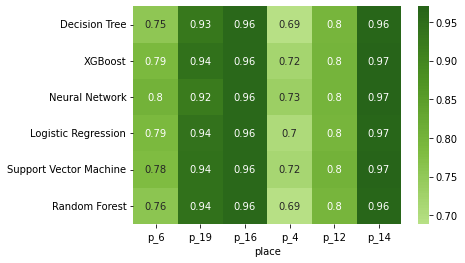

In [19]:
import seaborn as sns

sns.heatmap(res.transpose(), annot=True, cmap="PiYG", center=0.5)

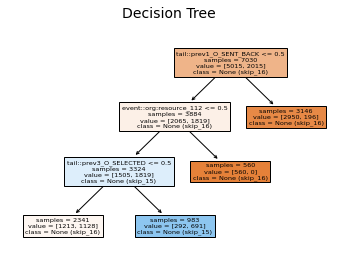

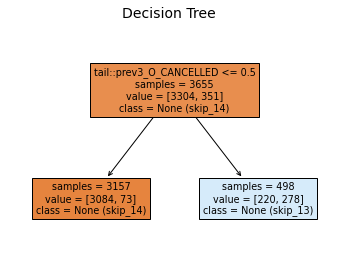

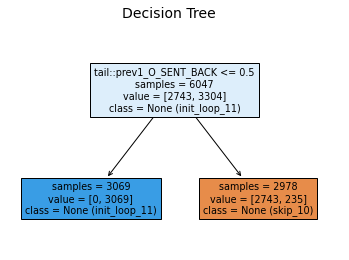

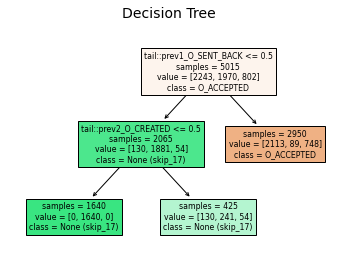

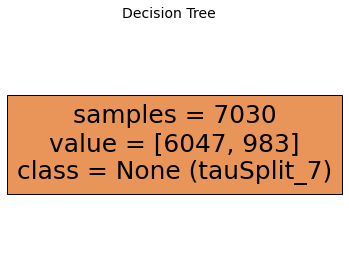

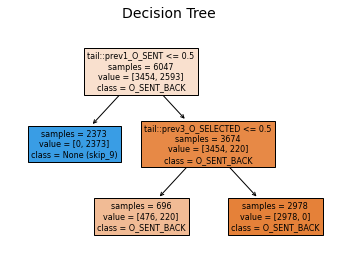

In [20]:
for _, gm in dpn.guard_manager_per_place.items():
    gm.guards_list[ML_Technique.DT].get_explainable_representation()